### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [7]:
#conda install -c conda-forge kaggle

In [ ]:
#!mkdir -p ~/.kaggle  - команда для создания папки .kaggle
#!cp kaggle.json ~/.kaggle/  - перенос файла апи каглл в папку
#!kaggle datasets download -d davinwijaya/customer-retention  -  загрузка датасета

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [2]:
import kaggle
# Загрузка датасета
kaggle.api.dataset_download_files('davinwijaya/customer-retention', path='./', unzip=True)
#что бы эта команда сработала у вас должен быть свой API kaggle json файл в папке .kaggle 

In [6]:
import pandas as pd
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


2.  поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [8]:
# преименование полей
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [9]:
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [6]:
# приведение значений к бинарным вариант 1
#df['treatment'] = df['treatment'].apply(lambda i : 0 if i == 'No Offer' else 1)
#df['treatment'].unique()

In [10]:
# приведение значений к бинарным вариант 2
df['treatment'] = df['treatment'].map({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0})
df['treatment'].unique(),df['treatment'].value_counts()

(array([1, 0], dtype=int64),
 1    42694
 0    21306
 Name: treatment, dtype: int64)

3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1),
                                                    df['target'],
                                                    test_size=0.30,
                                                    random_state=17)

4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

Для датасета "Customer Retention" можно рассмотреть следующие методы feature engineering:

- Преобразование категориальных признаков: Если в датасете есть категориальные признаки, можно применить методы кодирования, такие как One-Hot Encoding или Label Encoding, чтобы преобразовать их в числовые значения, понятные для модели машинного обучения.

- Создание временных признаков: Если в датасете есть данные о датах или времени, можно извлечь дополнительную информацию из них, например, день недели, месяц, год, время суток и т. д. Эти новые признаки могут содержать полезную информацию о паттернах и сезонности в данных.

- Создание агрегированных признаков: Если датасет содержит множество записей для каждого клиента, можно создать агрегированные признаки, суммируя, усредняя или вычисляя другие статистические метрики для каждого клиента. Например, можно рассчитать общее количество покупок, общую сумму потраченных денег, среднее время между покупками и т. д.

- Преобразование числовых признаков: Если числовые признаки в датасете имеют нелинейные распределения, можно применить преобразования, такие как логарифмическое или квадратное корень, чтобы сделать распределение более нормальным. Это может помочь модели машинного обучения в лучшем понимании данных.

- Создание признаков на основе предыдущих покупок: Если датасет содержит информацию о предыдущих покупках, можно создать признаки, связанные с поведением клиента. Например, можно рассчитать средний интервал между покупками, общее количество покупок за определенный период, последнюю покупку и т. д.

- Удаление или заполнение пропущенных значений: Если в датасете есть пропущенные значения, можно принять решение об их удалении или заполнении подходящими значениями, чтобы не потерять ценную информацию.

In [15]:
# One-Hot Encoding:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

5. провести uplift-моделирование 3 способами:
- одна модель с признаком коммуникации (S learner)
- модель с трансформацией таргета (трансформация классов п. 2. 1)
- вариант с двумя независимыми моделями

In [16]:
# Заведем переменные

treat_train = X_train['treatment']
treat_test = X_test['treatment']
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@30%': []
}

In [21]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
#!pip install scikit-uplift

In [22]:
#!pip install catboost

In [20]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from catboost import CatBoostClassifier

Модель с признаком коммуникации (S learner) - это метод в области причинно-следственного вывода, используемый для оценки эффекта воздействия на исследуемую переменную. Он является одним из подходов к оценке потенциального эффекта воздействия в сравнении с контрольной группой.

S learner использует машинное обучение для оценки причинных эффектов. Основная идея S learner заключается в том, чтобы построить две модели: одну модель для прогнозирования значения исследуемой переменной в зависимости от воздействия (т.е. воздейственной группы) и другую модель для прогнозирования значения исследуемой переменной без воздействия (т.е. контрольной группы). Затем разница между прогнозируемыми значениями воздейственной и контрольной групп используется для оценки эффекта воздействия.

Процесс работы S learner можно описать следующим образом:

Разделение данных на воздейственную и контрольную группы.
Построение модели для прогнозирования значения исследуемой переменной воздейственной группы.
Построение модели для прогнозирования значения исследуемой переменной контрольной группы.
Разница между прогнозируемыми значениями исследуемой переменной воздейственной и контрольной групп используется для оценки эффекта воздействия.
Модель S learner является гибким методом, который позволяет использовать различные алгоритмы машинного обучения для построения моделей воздейственной и контрольной групп. Это помогает учесть нелинейные зависимости и сложности в данных при оценке эффекта воздействия.

Однако важно отметить, что S learner предполагает, что нет ненаблюдаемых факторов (несбалансированность) между воздейственной и контрольной группами, которые могут влиять на исследуемую переменную. Если такие факторы присутствуют, необходимо использовать дополнительные методы для борьбы с ними, например, методы сопоставления по ближайшим соседям или методы рандомизации.

Общий подход S learner является одним из нескольких методов, которые могут быть использованы для оценки эффекта воздействия в исследованиях причинно-следственной связи. Другие подходы включают D learner, T learner и X learner.

D learner (двойная модель) - использует две модели для прогнозирования значения исследуемой переменной: одну для воздейственной группы и другую для контрольной группы. Затем разница между прогнозами двух моделей используется для оценки эффекта воздействия.

T learner (тройная модель) - использует три модели: одну для воздейственной группы, одну для контрольной группы и одну для всего набора данных. Затем сравниваются прогнозы трех моделей для оценки эффекта воздействия.

X learner (расширенная модель) - комбинирует D learner и T learner, используя две модели для воздейственной группы, две модели для контрольной группы и одну модель для всего набора данных. X learner пытается получить лучшую оценку эффекта воздействия, комбинируя прогнозы различных моделей.

Выбор между S learner, D learner, T learner и X learner зависит от характеристик данных, доступных модели и специфики исследования. Каждый метод имеет свои преимущества и ограничения, и важно выбрать подход, наиболее соответствующий вашим данным и исследовательским вопросам.

Важно отметить, что для успешного использования моделей с признаком коммуникации требуется качественная предобработка данных, корректное формирование воздейственной и контрольной групп, а также правильный выбор моделей прогнозирования для оценки эффекта воздействия. Также рекомендуется использовать методы кросс-проверки и другие проверки модели для оценки ее качества и обобщающей способности.

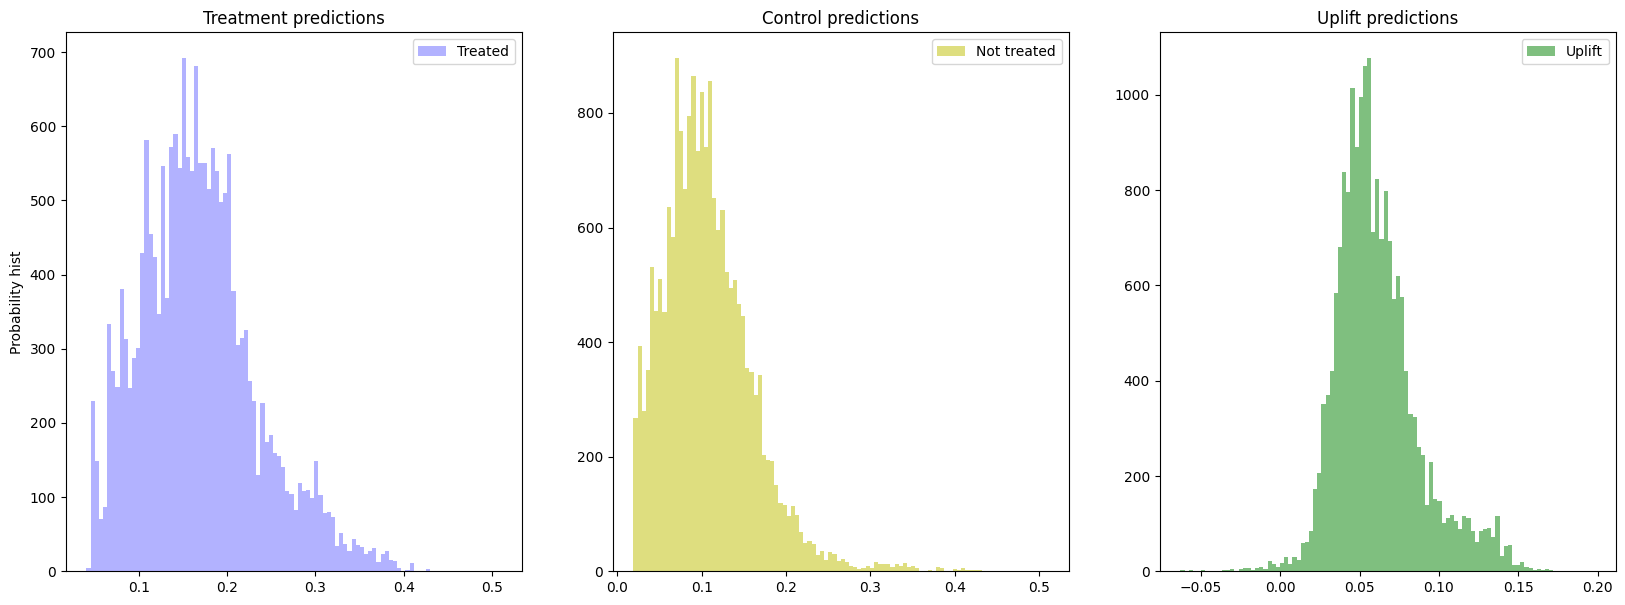

In [23]:
from sklift.models import SoloModel

# - модель с признаком коммуникации (S learner)
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=17, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

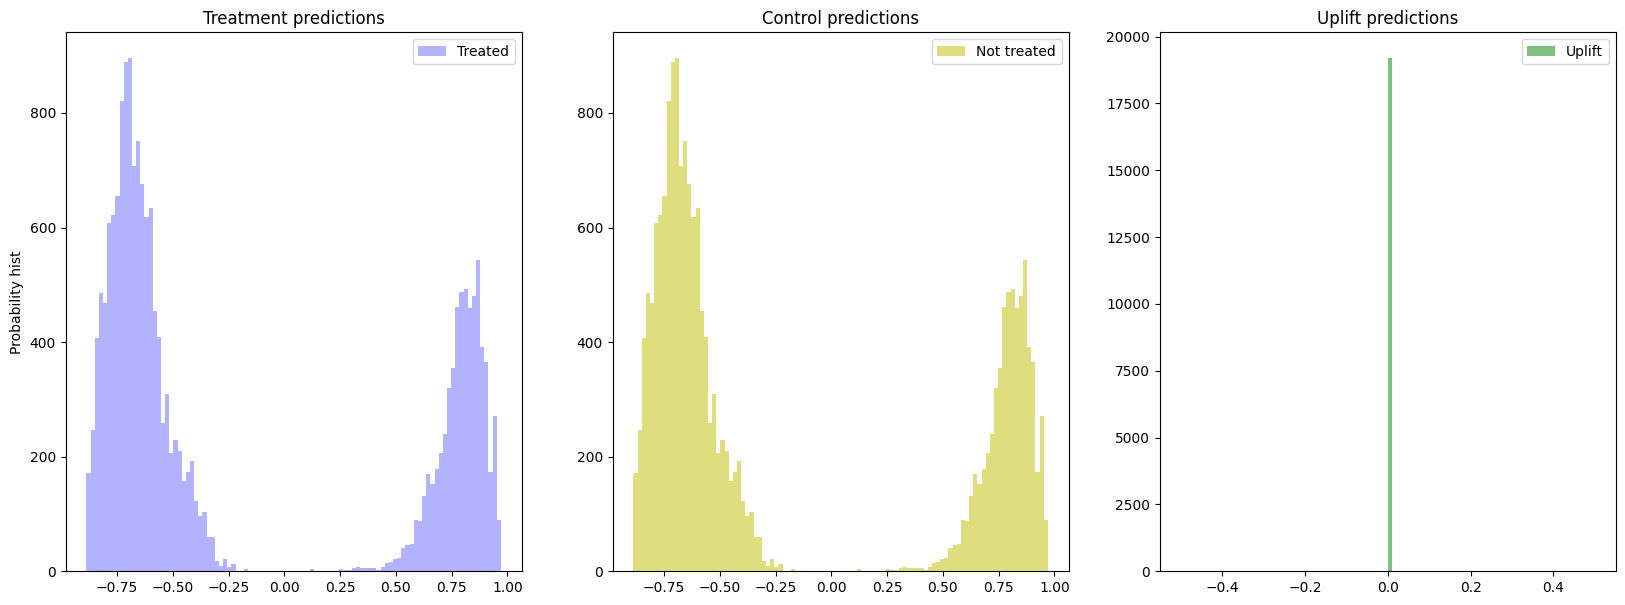

In [24]:
from sklift.models import ClassTransformation

# - модель с трансформацией таргета (трансформация классов п. 2. 1)
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=17, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@30%'].append(ct_score_30)

# Отрисуем распределения вероятностей и их разность (uplift)
uplift_visualization = plot_uplift_preds(trmnt_preds=ct.predict(X_test), ctrl_preds=ct.predict(X_test))

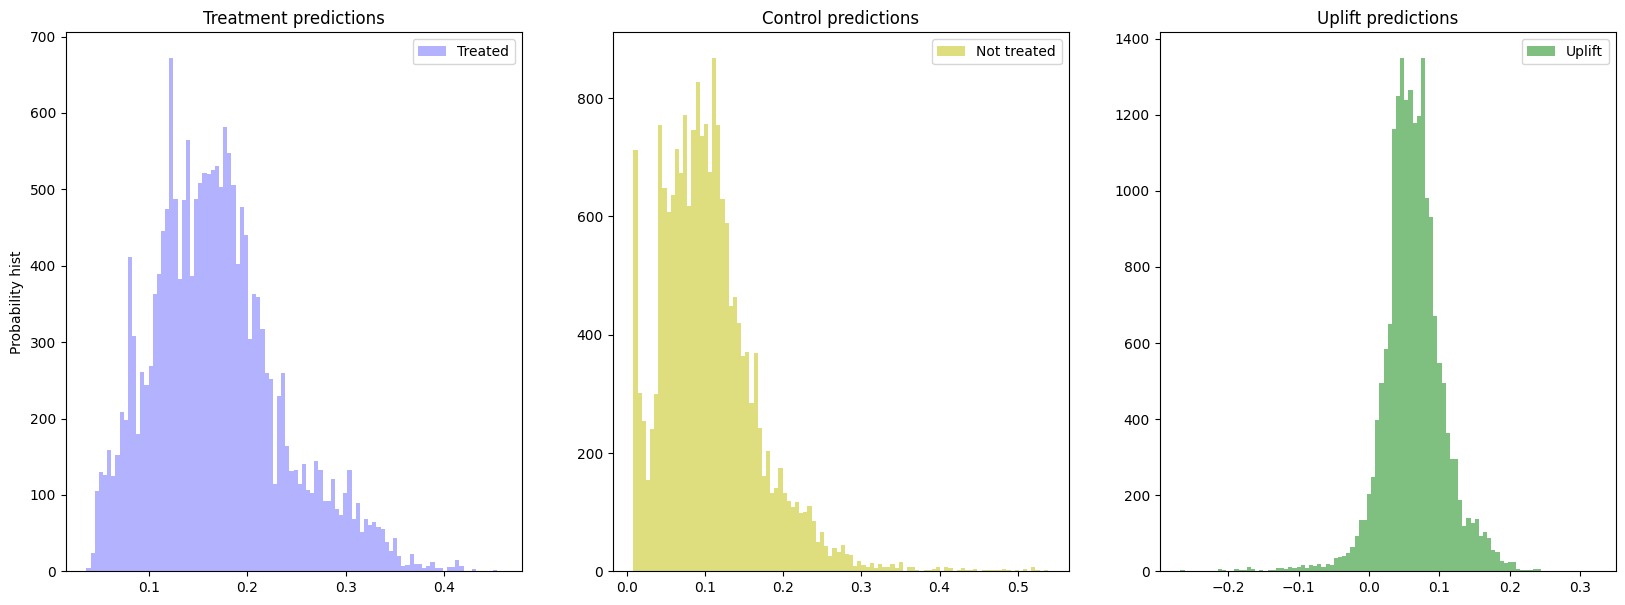

In [25]:
from sklift.models import TwoModels

# - вариант с двумя независимыми моделями
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=17, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=17, silent=True), 
    method='vanilla')

tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@30%'].append(tm_score_30)

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [26]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False).set_index('approach')

,uplift@10%,uplift@30%
approach,,
ClassTransformation,0.251313,0.173962
SoloModel,0.100859,0.074956
TwoModels,0.092975,0.072031


7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [27]:

from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

ModuleNotFoundError: No module named 'causalml.inference'

In [40]:
!pip install causalml

  Using cached causalml-0.13.0.tar.gz (535 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [800 lines of output]
  C:\Users\SAMOL\anaconda3\envs\GB_2023_pyton_31011\lib\site-packages\setuptools\installer.py:27: SetuptoolsDeprecationWarning: setuptools.installer is deprecated. Requirements should be satisfied by a PEP 517 installer.
    warnings.warn(
  
  Error compiling Cython file:
  ------------------------------------------------------------
  ...
  # cython: language_level=3
  # cython: linetrace=True
  
  from sklearn.tree._tree cimport Tree, TreeBuilder
  from sklearn.tree._tree cimport Splitter, SplitRecord
  from sklearn.tree._utils cimport StackRecord, Stack
  ^
  ------------------------------------------------------------
  
  causalml\inference\tree\causal\builder.pyx:9:0: 'sklearn\tree\_utils\StackRecord.pxd' not found
  
  Error compiling Cython file:
  ------------------------------------------------------------
  ...
  # cython: language_level=3


Для системы windows нет пакета  causalml.  Перепробовано всё. Без пакета не получается построить графическое отображение дерева.

In [43]:
# https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html#install-using-homebrew
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

ModuleNotFoundError: No module named 'causalml.inference'

In [41]:
!git clone https://github.com/uber-common/causalml.git

fatal: destination path 'causalml' already exists and is not an empty directory.


In [42]:
!pip install graphviz

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier, \
                                        uplift_tree_string, uplift_tree_plot
from catboost import CatBoostClassifier
import warnings

ModuleNotFoundError: No module named 'causalml.inference'

In [44]:
!pip install -i https://pypi.anaconda.org/ppstacy/simple causalml

Looking in indexes: https://pypi.anaconda.org/ppstacy/simple
     ---------------------------------------- 0.0/404.3 kB ? eta -:--:--
     ---------------------------------------- 0.0/404.3 kB ? eta -:--:--
     ---------------------------------------- 0.0/404.3 kB ? eta -:--:--
     ---------------------------------------- 0.0/404.3 kB ? eta -:--:--
     ---- ----------------------------------- 41.0/404.3 kB ? eta -:--:--
     ---- ----------------------------------- 41.0/404.3 kB ? eta -:--:--
     ---- ----------------------------------- 41.0/404.3 kB ? eta -:--:--
     ---- -------------------------------- 51.2/404.3 kB 262.6 kB/s eta 0:00:02
     --------- -------------------------- 102.4/404.3 kB 535.8 kB/s eta 0:00:01
     --------- -------------------------- 102.4/404.3 kB 535.8 kB/s eta 0:00:01
     --------- -------------------------- 102.4/404.3 kB 535.8 kB/s eta 0:00:01
     -------------------- --------------- 225.3/404.3 kB 625.1 kB/s eta 0:00:01
     --------------------

  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [101 lines of output]
  C:\Users\SAMOL\anaconda3\envs\GB_2023_pyton_31011\lib\site-packages\setuptools\installer.py:27: SetuptoolsDeprecationWarning: setuptools.installer is deprecated. Requirements should be satisfied by a PEP 517 installer.
    warnings.warn(
  c:\users\samol\appdata\local\temp\pip-install-b3qmoeba\causalml_8a25ef961f6e4e98b040b15e773ad0b4\.eggs\cython-0.29.34-py3.10.egg\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\SAMOL\AppData\Local\Temp\pip-install-b3qmoeba\causalml_8a25ef961f6e4e98b040b15e773ad0b4\causalml\inference\tree\causaltree.pyx
    tree = Parsing.p_module(s, pxd, full_module_name)
  
  Error compiling Cython file:
  ------------------------------------------------------------
  ...
          cdef SIZE_t p
          cdef DOUBLE_t

In [45]:
uplift_model = UpliftTreeClassifier(max_depth=8, 
                                    min_samples_leaf=200, 
                                    min_samples_treatment=50,
                                    n_reg=100, 
                                    evaluationFunction='KL', 
                                    control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

NameError: name 'UpliftTreeClassifier' is not defined

8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Ссылки

1. https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
2. https://habr.com/ru/company/ru_mts/blog/485980/#reference1
3. https://en.wikipedia.org/wiki/Uplift_modelling
4. https://www.youtube.com/watch?v=yFQAIJBYXI0
5. https://www.youtube.com/watch?v=jCUcYiBK03I
6. https://www.uplift-modeling.com/en/latest/
7. https://arxiv.org/pdf/1809.04559.pdf
8. https://catboost.ai/docs/concepts/about.html

### Библиотеки и пакеты

1. causalml
2. sklift
3. catboost